# Testing the optimization run for convergence

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import os

from ema_workbench import Model, RealParameter, ScalarOutcome, HypervolumeMetric, GenerationalDistanceMetric
from ema_workbench.em_framework import ArchiveLogger, epsilon_nondominated 
from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem

from experimentation import data_generation
from model.model_nile import ModelNile
from tqdm import tqdm


In [2]:
# # sns.set(font_scale=1.2)

# fm.fontManager.addfont("Minion Pro Regular.ttf")
# matplotlib.rc("font", family="Minion Pro")

# rcParams["font.family"] = "Minion Pro"
# rcParams["font.sans-serif"] = "Minion Pro"
# rcParams["font.size"] = 12

## 1. Data colleciton

### 1.1 The models used for experiments

In [3]:
# Define the subfolder names corresponding to different experiments.
different_principles = ["nfe50000_uwf_001_demand", "nfe50000_pwf_100_demand", "nfe50000_gini_01_demand"]
different_seeds = ["nfe50000_pwf_100_demand"]
subfoldernames = different_principles

In [4]:
def get_principle(s):
    for principle in ["None", "uwf", "pwf", "gini"]:
        if principle in s:
            return principle
    raise ValueError("Invalid string, principle not recognized.")

In [5]:
def create_em_model(principle):
    nile_model = ModelNile(principle=principle)
    nile_model = data_generation.generate_input_data(nile_model, sim_horizon=20)
    
    em_model = Model("NileProblem", function=nile_model)

    parameter_count = nile_model.overarching_policy.get_total_parameter_count()
    n_inputs = nile_model.overarching_policy.functions["release"].n_inputs
    n_outputs = nile_model.overarching_policy.functions["release"].n_outputs
    p_per_RBF = 2 * n_inputs + n_outputs

    lever_list = list()
    for i in range(parameter_count):
        modulus = (i - n_outputs) % p_per_RBF
        if (
            (i >= n_outputs)
            and (modulus < (p_per_RBF - n_outputs))
            and (modulus % 2 == 0)
        ):  # centers:
            lever_list.append(RealParameter(f"v{i}", -1, 1))
        else:  # linear parameters for each release, radii, and weights of RBFs:
            lever_list.append(RealParameter(f"v{i}", 0, 1))

    em_model.levers = lever_list

    # specify outcomes
    em_model.outcomes = [
        ScalarOutcome("egypt_agg_deficit_ratio", ScalarOutcome.MINIMIZE),
        ScalarOutcome("egypt_90p_deficit_ratio", ScalarOutcome.MINIMIZE),
        ScalarOutcome("egypt_low_had_frequency", ScalarOutcome.MINIMIZE),
        ScalarOutcome("sudan_agg_deficit_ratio", ScalarOutcome.MINIMIZE),
        ScalarOutcome("sudan_90p_deficit_ratio", ScalarOutcome.MINIMIZE),
        ScalarOutcome("ethiopia_agg_deficit_ratio", ScalarOutcome.MINIMIZE),
    ]
    if principle != "None":
        em_model.outcomes.extend([ScalarOutcome("principle_result", ScalarOutcome.MAXIMIZE)])
    
    return em_model

In [6]:
problems = {}
for subfolder in subfoldernames:
    print(subfolder)
    principle = get_principle(subfolder)
    print("principle:", principle)
    em_model = create_em_model(principle)
    print("number of outcomes:", len(em_model.outcomes))
    problem = to_problem(em_model, searchover="levers")
    problems[subfolder] = problem

nfe50000_uwf_001_demand
principle: uwf


number of outcomes: 7
nfe50000_pwf_100_demand
principle: pwf
number of outcomes: 7
nfe50000_gini_01_demand
principle: gini
number of outcomes: 7


### 1.2 Results from experiments for different principles and multiple seeds

In [7]:
all_subfolder_results = {}
all_subfolder_convergences = {}
for subfolder in subfoldernames:
    print("---", subfolder, "---")
    results = {}
    convergences = {}

    for i in range(5):
        print(i)
        # Construct the path to the subfolder.
        subfolderpath = f"outputs/{subfolder}" 
        
        # Construct the file paths for the results and convergence CSV files for the current experiment.
        results_filepath = f"{subfolderpath}/baseline_results_{subfolder}_s{i}.csv"
        convergence_filepath = f"{subfolderpath}/baseline_convergence_{subfolder}_s{i}.csv"

        # Read the CSV files into DataFrames.
        results[i] = pd.read_csv(results_filepath, index_col=0)
        convergences[i] = pd.read_csv(convergence_filepath, index_col=[0])

        print(f"Shape of result for experiment {subfolder} and seed {i}: {results[i].shape}")
        print(f"Shape of convergence for experiment {subfolder} and seed {i}: {convergences[i].shape}")
    
    # Store results and convergences in dictionaries with subfolder names as keys
    all_subfolder_results[subfolder] = results
    all_subfolder_convergences[subfolder] = convergences
    print(f"Number of elements in 'results': {len(results)}")
    print(f"Number of elements in 'convergences': {len(convergences)}")

--- nfe50000_uwf_001_demand ---
0
Shape of result for experiment nfe50000_uwf_001_demand and seed 0: (200, 171)
Shape of convergence for experiment nfe50000_uwf_001_demand and seed 0: (20, 2)
1
Shape of result for experiment nfe50000_uwf_001_demand and seed 1: (196, 171)
Shape of convergence for experiment nfe50000_uwf_001_demand and seed 1: (20, 2)
2
Shape of result for experiment nfe50000_uwf_001_demand and seed 2: (178, 171)
Shape of convergence for experiment nfe50000_uwf_001_demand and seed 2: (22, 2)
3
Shape of result for experiment nfe50000_uwf_001_demand and seed 3: (176, 171)
Shape of convergence for experiment nfe50000_uwf_001_demand and seed 3: (21, 2)
4
Shape of result for experiment nfe50000_uwf_001_demand and seed 4: (186, 171)
Shape of convergence for experiment nfe50000_uwf_001_demand and seed 4: (21, 2)
Number of elements in 'results': 5
Number of elements in 'convergences': 5
--- nfe50000_pwf_100_demand ---
0
Shape of result for experiment nfe50000_pwf_100_demand and 

### Hypervolume and Generational distance with Platypus Metrics
To evaluate optimization convergence, we use Hypervolume and Generational Distance metrics from Platypus. For precise analysis, we need to load the necessary archived data into memory.

In [8]:
all_subfolder_archives = {}
# Loop through each subfolder (representing different experiments).
for subfolder in subfoldernames:
    # Initialize an empty list to store archives for each seed experiment.
    subfolderpath = f"outputs/{subfolder}" 
    all_archives = {}
    for i in range(5):
        # Construct the path to the current experiment's output folder and the archive file for the current experiment.
        # subfolderpath = f"outputs/{subfolder}"
        archive_path = f"{subfolderpath}/archive_logs/{i}.tar.gz"
        
        # Load the archives using the provided ArchiveLogger function.
        archives = ArchiveLogger.load_archives(archive_path)

        # Drop the first column from each archive dataframe
        for key in archives:
            archives[key] = archives[key].iloc[:, 1:]
        
        # Append the loaded archives to the main list.
        all_archives[i] = archives
    all_subfolder_archives[subfolder] = all_archives

In [9]:
for subfolder, all_archives in all_subfolder_archives.items():
        print("---", subfolder, "---")
        print(f"Total number of archives: {len(all_archives)}")
        for seed, archive in all_subfolder_archives[subfolder].items():
            print(f"Archive {seed}: {len(archive)} items")

--- nfe50000_uwf_001_demand ---
Total number of archives: 5
Archive 0: 20 items
Archive 1: 20 items
Archive 2: 22 items
Archive 3: 21 items
Archive 4: 21 items
--- nfe50000_pwf_100_demand ---
Total number of archives: 5
Archive 0: 22 items
Archive 1: 21 items
Archive 2: 20 items
Archive 3: 22 items
Archive 4: 21 items
--- nfe50000_gini_01_demand ---
Total number of archives: 5
Archive 0: 22 items
Archive 1: 21 items
Archive 2: 20 items
Archive 3: 22 items
Archive 4: 20 items


#### Convergence resultst

In [10]:
reference_set_dict = {}
hv_dict = {}
gd_dict = {}

for subfolder in subfoldernames:
    # Construct the path to the subfolder.
    # subfolderpath = f"outputs/{subfolder}" 
    print("---", subfolder, "---")
    # Construct the path to the subfolder.
    subfolderpath = f"outputs/{subfolder}" 
    # Construct the file paths for the results and convergence CSV files for the current experiment.
    reference_set_filepath = f"{subfolderpath}/baseline_results_{subfolder}.csv"
    reference_set = pd.read_csv(reference_set_filepath, index_col=0)
    print("The number of solutions after filtering:", len(reference_set))
    reference_set_dict[subfolder] = reference_set
    print(len(reference_set.columns))

    hv_dict[subfolder] = HypervolumeMetric(reference_set, problems[subfolder])
    gd_dict[subfolder] = GenerationalDistanceMetric(reference_set, problems[subfolder], d=1)


--- nfe50000_uwf_001_demand ---
The number of solutions after filtering: 219
171
--- nfe50000_pwf_100_demand ---


The number of solutions after filtering: 238
171
--- nfe50000_gini_01_demand ---
The number of solutions after filtering: 338
171


In [16]:
for subfolder, all_archives in all_subfolder_archives.items():
    subfolderpath = f"outputs/{subfolder}" 
    print(subfolder)
    metrics_by_seed = []
    hv = hv_dict[subfolder]
    gd = gd_dict[subfolder]
    # print(subfolder, "\n", all_archives)
    # Iterate over each archive, hv, and gd simultaneously
    for seed, archive in all_archives.items():
        print(seed)
        metrics = []
        print(len(archive.keys()))
        for nfe, arch in tqdm(archive.items(), desc="Processing NFEs"):
            print(nfe)
            scores = {
                "generational_distance": gd.calculate(arch),
                "hypervolume": hv.calculate(arch),
                "nfe": int(nfe)
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)
        # Sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        metrics_by_seed.append(metrics)
        convergence_filename = f"{subfolderpath}/convergence_results_seed{seed}.csv"
        metrics.to_csv(convergence_filename)

nfe50000_uwf_001_demand
0
20


Processing NFEs:   0%|          | 0/20 [00:00<?, ?it/s]

0
100
10360


Processing NFEs:  15%|█▌        | 3/20 [13:42<1:17:41, 274.20s/it]

13240


Processing NFEs:  20%|██        | 4/20 [34:20<2:36:01, 585.07s/it]

16120


Processing NFEs:  25%|██▌       | 5/20 [1:09:05<4:24:32, 1058.14s/it]

19000


Processing NFEs:  30%|███       | 6/20 [1:43:44<5:20:54, 1375.29s/it]

21880


Processing NFEs:  35%|███▌      | 7/20 [2:33:34<6:45:33, 1871.80s/it]

24760


Processing NFEs:  40%|████      | 8/20 [3:30:06<7:47:07, 2335.58s/it]

2600


Processing NFEs:  45%|████▌     | 9/20 [3:33:45<5:10:23, 1693.04s/it]

27640


Processing NFEs:  50%|█████     | 10/20 [4:38:46<6:33:28, 2360.87s/it]

30520


Processing NFEs:  55%|█████▌    | 11/20 [5:44:43<7:06:23, 2842.65s/it]

33400


Processing NFEs:  60%|██████    | 12/20 [6:56:55<7:18:48, 3291.05s/it]

36280


Processing NFEs:  60%|██████    | 12/20 [7:28:28<4:58:59, 2242.40s/it]


KeyboardInterrupt: 

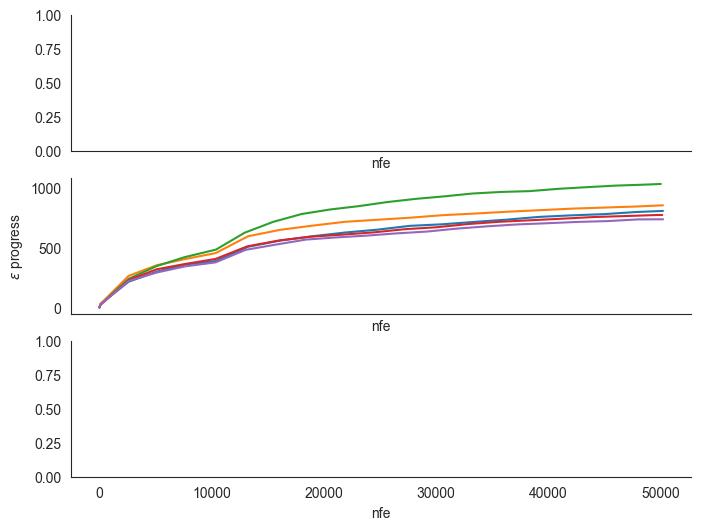

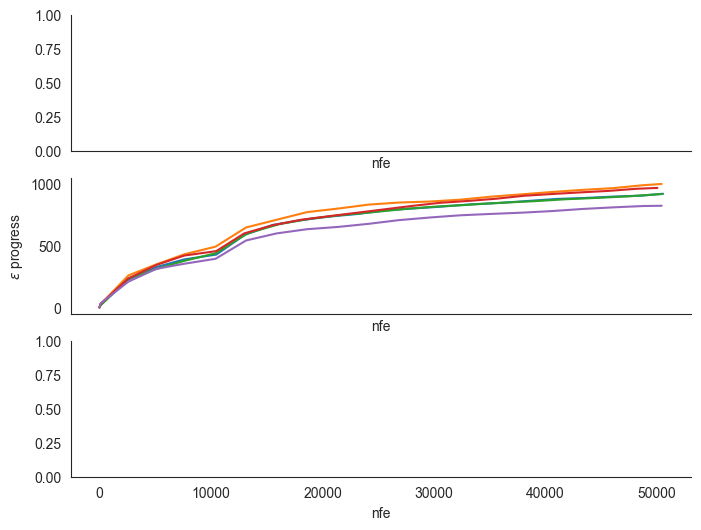

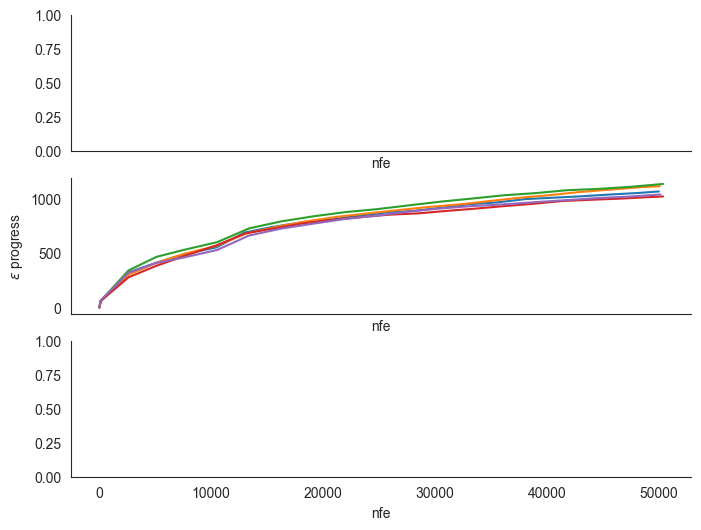

In [10]:
sns.set_style("white")

for subfolder, convergences in all_subfolder_convergences.items():
    subfolderpath = f"outputs/{subfolder}"

    fig, axes = plt.subplots(nrows=3, figsize=(8, 6), sharex=True)
    ax1, ax2, ax3 = axes

    for seed in range(5):
        # convergence_filename = f"{subfolderpath}/convergence_results_seed{seed}.csv"
        # metrics = pd.read_csv(convergence_filename)
        # metrics_by_seed[seed] = metrics
        

        # ax1.plot(metrics.nfe, metrics.hypervolume)
        # ax1.set_ylabel("hypervolume")
        
        ax2.plot(convergences[seed].nfe, convergences[seed].epsilon_progress)
        ax2.set_ylabel("$\epsilon$ progress")

        # ax3.plot(metrics.nfe, metrics.generational_distance)
        # ax3.set_ylabel("generational distance")

    for ax in axes:
        ax.set_xlabel("nfe")

    sns.despine(fig)

    plt.show()